# Collector

In [122]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import openpyxl

import os.path
from os import path
import time

# import sklearn
# import scipy

# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lightgbm
# from xgboost import XGBClassifier
# import keras

# Get Started
# https://github.com/Refinitiv-API-Samples/Article.EikonDataAPI.DotNet.Library
# API limits
# https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation?content=49692&type=documentation_item
import eikon as ek 

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [123]:
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

In [124]:
# Зададим path для папки проекта и для папок файлов
path_project_folder = 'C:/DAN/t_systems/trade_project/'
folder_name_headlines = 'backup_headlines/'
folder_name_logger = 'logger/'

In [125]:
# Для работы с API нужен запущенный терминал Thomson Reuters Eikon
# Зададим API ключ - не даёт доступ сам по себе
ek.set_app_key('ccebd1ff788d4574818be93e35c4741925ac214e') # df6c94f7d0fb4b4e80533d1c2f86daf402ce52c0

In [126]:
# https://community.developers.refinitiv.com/questions/67592/eikon-json-requests-incorrect-and-eikon-data-api-h.html
# httpx 0.15.x or 0.16.x => need to downgrade to 0.14.3 (pip install httpx==0.14.3)
# nest-asyncio 1.4.x => need to downgrade to 1.3.3 (pip install nest-asyncio==1.3.3)

# Подгрузим файлы с компаниями, которые хотим выгружать

In [127]:
rics_german_df = pd.read_excel(path_project_folder + 'rics_german_excel.xlsx', engine='openpyxl')
sort_cols = ['DAX', 'German_telecom', 'Company Market Cap']
rics_german_df = rics_german_df.sort_values(by=sort_cols, ascending=False) # .reset_index(drop=True)
rics_german_df.index = range(0, len(rics_german_df))
rics_german_df

,ric,Company Common Name,Country of Exchange,Primary Country of Risk,TRBC Industry Group Name,TRBC Industry Name,Price Close,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,Germany,Germany,Telecommunications Services,Integrated Telecommunications Services,18.032030,8.580246e+10,1,1
1,SAPG.DE,SAP SE,Germany,Germany,Software & IT Services,Software,122.335901,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,Germany,Germany,Consumer Goods Conglomerates,Consumer Goods Conglomerates,139.347250,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,Germany,Germany,Insurance,Multiline Insurance & Brokers,235.534278,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,Germany,Germany,Automobiles & Auto Parts,Auto & Truck Manufacturers,182.653284,9.619011e+10,1,0
...,...,...,...,...,...,...,...,...,...,...
1486,IXM0392.DE,MSCI Pac ex Jap ETF,Germany,NaN,NaN,NaN,164.045417,NaN,0,0
1487,IXM0402.DE,MSCI Canada ETF,Germany,NaN,NaN,NaN,147.258410,NaN,0,0
1488,IXM0422.DE,MSCI USA ETF,Germany,NaN,NaN,NaN,368.704250,NaN,0,0
1489,IXM0432.DE,MSCI Jap ETF,Germany,NaN,NaN,NaN,179.058138,NaN,0,0


In [128]:
condition_german = rics_german_df['Country of Exchange'] == 'Germany'
condition_telecom = rics_german_df['TRBC Industry Group Name'] == 'Telecommunications Services'
rics_german_telekom_df = rics_german_df[condition_german & condition_telecom]
rics_german_telekom_df[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,8.580246e+10,1,1
27,O2Dn.DE,Telefonica Deutschland Holding AG,8.088962e+09,0,1
28,UTDI.DE,United Internet AG,7.962405e+09,0,1
29,DRIG.DE,1&1 Drillisch AG,4.331541e+09,0,1
30,FNTGn.DE,freenet AG,2.614030e+09,0,1
31,TC1n.DE,Tele Columbus AG,3.688837e+08,0,1
32,NFN.DE,NFON AG,3.245050e+08,0,1
33,E4CG.DE,Ecotel Communication AG,3.558930e+07,0,1
34,PH6.F,Philion SE,2.065664e+05,0,1


In [129]:
condition_dax = (rics_german_df['DAX'] == 1) & (rics_german_df['German_telecom'] != 1)
rics_dax = rics_german_df[condition_dax]
rics_dax[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
1,SAPG.DE,SAP SE,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,9.619011e+10,1,0
5,DAIGn.DE,Daimler AG,7.532200e+10,1,0
6,BASFn.DE,BASF SE,7.222737e+10,1,0
7,ADSGn.DE,Adidas AG,7.062461e+10,1,0
8,DPWGn.DE,Deutsche Post AG,5.932596e+10,1,0
9,BMWG.DE,Bayerische Motoren Werke AG,5.780708e+10,1,0
10,BAYGn.DE,Bayer AG,5.621811e+10,1,0


In [130]:
rics_usa_df = pd.read_excel(path_project_folder + 'rics_usa_excel.xlsx', engine='openpyxl')
print('fisrt top-200 companies by market cap:', '\n', list(rics_usa_df['Company Common Name'])[:100])

fisrt top-200 companies by market cap: 
 ['Apple Inc', 'Microsoft Corp', 'Amazon.com Inc', 'Alphabet Inc', 'Tesla Inc', 'Facebook Inc', 'Alibaba Group Holding Ltd', 'Berkshire Hathaway Inc', 'Visa Inc', 'Johnson & Johnson', 'Walmart Inc', 'JPMorgan Chase & Co', 'Mastercard Inc', 'UnitedHealth Group Inc', 'Procter & Gamble Co', 'NVIDIA Corp', 'Walt Disney Co', 'Home Depot Inc', 'PayPal Holdings Inc', 'Bank of America Corp', 'Ishares S&P 500', 'Verizon Communications Inc', 'Comcast Corp', 'Adobe Inc', 'Nike Inc', 'Netflix Inc', 'Pinduoduo Inc', 'Coca-Cola Co', 'Intel Corp', 'Merck & Co Inc', 'Vanguard Idx Fund', 'AT&T Inc', 'Pfizer Inc', 'Salesforce.Com Inc', 'Thermo Fisher Scientific Inc', 'PepsiCo Inc', 'Abbott Laboratories', 'Exxon Mobil Corp', 'Cisco Systems Inc', 'Abbvie Inc', 'Oracle Corp', 'Vanguard 500 Index Fund', 'Broadcom Inc', 'Qualcomm Inc', 'Chevron Corp', 'Accenture PLC', 'Danaher Corp', 'T-Mobile US Inc', 'Costco Wholesale Corp', 'Medtronic PLC', "Mcdonald's Corp", 'Eli L

In [131]:
rics_usa_df[['TRBC Industry Group Name', 'ric']].groupby(['TRBC Industry Group Name']).agg(
    rics_count=('ric', 'count')
).sort_values(by='rics_count', ascending=False).head(5)

,rics_count
TRBC Industry Group Name,
Software & IT Services,303
Biotechnology & Medical Research,257
Banking Services,232
Residential & Commercial REITs,174
Collective Investments,172


# Подгрузим функции, которые использую в большом цикле

In [132]:
def get_name_of_latest_file_in_folder(folder_name):
    """
    Get all file names in selected direction.
    Return the latest file in that directory.
    """
    files_creation_dates = pd.DataFrame(data = [], columns=[
        "folder_name", "file_name", "num_time", "str_time"
    ])

    files_creation_dates['file_name'] = os.listdir(folder_name)
    files_creation_dates['folder_name'] = folder_name
    files_creation_dates['file_folder_and_name'] = files_creation_dates['folder_name'] + files_creation_dates['file_name']
    files_creation_dates
    for i in range(0, len(files_creation_dates)):
        file_folder_and_name = files_creation_dates['file_folder_and_name'][i]
        files_creation_dates['num_time'][i] = os.path.getctime(file_folder_and_name)
        files_creation_dates['str_time'][i] = time.ctime(os.path.getctime(file_folder_and_name))

    latest_file_dir = files_creation_dates.sort_values(by=['num_time'], ascending=False)['file_folder_and_name'].iloc[0]
    
    return latest_file_dir

In [133]:
# Создадим df, в который будем сохранять вообще все новости.

# Можем создать пустой df, куда будем добавлять все новости
# all_headlines_df = pd.DataFrame(data = [], columns=["ric", "versionCreated", "headline", "storyId", "sourceCode", "story"])

# Но если мы уже сохраняли файл, достанем самый свежий из папки
latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_headlines)
all_headlines_df = pd.read_csv(latest_file, sep=';')
all_headlines_df['versionCreated'] = pd.to_datetime(all_headlines_df['versionCreated'])
print(all_headlines_df.shape, latest_file)

(389246, 6) C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-03-11_v5.csv


In [134]:
# Создадим подобие logger'а 

# quasi_logger = pd.DataFrame(data = [], columns=[
#     'ric_i', 'ric_now', 'headlines_slice_i', 'headlines_number',
#     'up_to_date_ric', 'story_i', 'story_id_now', 'story_is_success', 
#     'date_time',
# ])

# Так как у нас уже есть созданный logger, подгрузим его
latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_logger)
quasi_logger = pd.read_csv(latest_file, sep=';')
# quasi_logger['date_time'] = pd.to_datetime(quasi_logger['date_time'])
# print(quasi_logger.shape, latest_file)

c:\python37\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [135]:
quasi_logger[-5:]

,ric_i,ric_now,headlines_slice_i,headlines_number,up_to_date_ric,story_i,story_id_now,story_is_success,date_time
358580,37,XOM.N,32.0,100.0,2020-07-31 13:55:37+00:00,95.0,urn:newsml:reuters.com:20200730:nRTV9GwS1R:5,False,2021-03-11 04:10:07.763471
358581,37,XOM.N,32.0,100.0,2020-07-31 13:55:37+00:00,96.0,urn:newsml:reuters.com:20200730:nL5N2F1515:1,False,2021-03-11 04:10:13.032374
358582,37,XOM.N,32.0,100.0,2020-07-31 13:55:37+00:00,97.0,urn:newsml:reuters.com:20200730:nL5N2F15C4:3,False,2021-03-11 04:10:18.302284
358583,37,XOM.N,32.0,100.0,2020-07-31 13:55:37+00:00,98.0,urn:newsml:reuters.com:20200730:nL5N2F14OY:5,False,2021-03-11 04:10:23.588161
358584,37,XOM.N,32.0,100.0,2020-07-31 13:55:37+00:00,99.0,urn:newsml:reuters.com:20200730:nL5N2F13E8:9,False,2021-03-11 04:10:28.861063


In [136]:
# Проверим, содержит ли all_headlines_df наш текущий ric
def set_value_of_up_to_date_ric(
        ric_now, # ric to check of existence in df
        df_with_news_to_check,
        column_name_with_rics = 'ric',
        column_name_with_dates = 'versionCreated'):
    """
    This function is checking the existance of ric in chosen df.
    If some news are in df, then function returns the oldest date in df.
    If no news are in df, then function returns 'None' for ek.get_news_headlines.
    """

    is_this_ric_in_all = ric_now in list(df_with_news_to_check[column_name_with_rics])
    print()
    print('is_this_ric_in_all:', is_this_ric_in_all, end=' ')
    if is_this_ric_in_all:
        # Если в нашем датасете присутствует этот ric,
        # то продолжаем по нему выгружать, берём мин имеющуюся дату.
        up_to_date_ric = str(df_with_news_to_check[df_with_news_to_check[column_name_with_rics] == ric_now][column_name_with_dates].min())
        print('  up_to_date_ric:', up_to_date_ric, end=' ')
    else:
        # None означает, что метод ek.get_news_headlines возьмёт текущий момент времени.
        up_to_date_ric = None
        print('  up_to_date_ric:', up_to_date_ric, end=' ')
        
    return up_to_date_ric

In [137]:
def get_news_headlines_with_some_tries(
        ric_now,
        headlines_count_to_request,
        up_to_date_ric,
        max_num_tries=5):
    """
    We trying to get df with headlines from eikon API with several tries
    """
    
    tries_num = 0
    while tries_num < max_num_tries:
        try:
            news_get_df = ek.get_news_headlines(
                query=ric_now,
                count=headlines_count_to_request,
                date_to=up_to_date_ric
            )
            print('got successfully', end=' ')
            break
        except Exception as e:
            print()
            print('Error when trying to get news headlines', tries_num)
            print(e)
            time.sleep(5)
            tries_num = tries_num + 1

    print('news_get_df.shape:', news_get_df.shape[0])

    return news_get_df

In [138]:
def prepare_headlines_df_to_adding_news_story(
        ric_now,
        news_get_df):
    """
    Now: news_get_df is collected df from ek.get_news_headlines method.
    And we want to add news story (full news text) to that df.
    So we should prepare that df for iterations with ek.get_news_story method.
    For that puspose we should add ric and story columns,
    and change the column name with headlines from text to headlines.
    """
    
    news_get_df = news_get_df.reset_index(drop=True) # чтобы юзать .loc()
    news_get_df['ric'] = ric_now
    news_get_df['story'] = np.nan
    news_get_df['headline'] = news_get_df['text']
    news_get_df = news_get_df.drop(columns=['text'])
    
    return news_get_df

In [139]:
def adding_news_stories_to_df_with_headlines(
        news_get_df,
        quasi_logger,
        ric_i,
        ric_now,
        headlines_slice_i,
        headlines_number,
        up_to_date_ric,
        col_name_with_story_id = 'storyId'):
    """
    The function adds full text news story to df with headlines using storyId.
    The function just prints the error in a case of error (they are rare).
    In any case the function logs results of API request to logger df.
    """

    for story_i in range(0, len(news_get_df)): # range(0, len(news_get_df))
        story_id_now = news_get_df['storyId'][story_i]

        try:
            story_now = ek.get_news_story(story_id_now)
            # Удалим из истории все тильды на всякий случай, будет sep='~'
            story_now = story_now.replace("~", "!tilda!")
            # Внесём выкаченную историю в df
            news_get_df.loc[story_i, 'story'] = story_now
            # Пометим, что мы успешно выкачали текст новости
            story_is_success = True
            print(story_i, end='; ')

        except Exception as e:
            story_is_success = False
            # Заменим NA на текст ошибки
            news_get_df.loc[story_i, 'story'] = 'error_when_trying_to_collect_story'
            # Выведем story с ошибкой
            print() # e.message
            print(
                'STORY IS OK:', story_is_success, 
                '  ric_now:', ric_now, # input to function
                '  ric_i:', ric_i, # input to function
                '  story_i:', story_i
                )
            print(e)
            time.sleep(5)

        finally:
            # В любом случае внесём в наш квази-логгер наблюдение story.
            quasi_logger = quasi_logger.append({
                "ric_i": ric_i, # input to function
                "ric_now": ric_now, # input to function
                "headlines_slice_i": headlines_slice_i, # input to function
                "headlines_number": headlines_number, # input to function
                "up_to_date_ric": up_to_date_ric, # input to function
                "story_i": story_i,
                "story_id_now": story_id_now,
                "story_is_success": story_is_success,
                "date_time": str(datetime.today())
            }, ignore_index = True)
    # At that moment the df has full text of news in col story
    return news_get_df, quasi_logger

In [140]:
def save_file_as_new_file_without_replacing(
        path_project_folder,
        folder_name_to_save,
        file_to_save,
        file_short_name_add_to_path):
    """
    Save the file to selected folder without replacing,
    but changing file name as a number of version at date now
    """
    # Сохраним версию all_headlines_df со всеми новостями
    # Подберём такое название, которого нет в dir, чтобы не переписывать файл.
    file_version = 1
    folder_name = path_project_folder + folder_name_to_save
    date_now = datetime.today().strftime("%Y-%m-%d")
    file_name = file_short_name_add_to_path + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    while file_name in os.listdir(folder_name):
        file_name = file_short_name_add_to_path + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
        file_version = file_version + 1
    # C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-24_v6.csv
    file_path = folder_name + file_name
    file_to_save.to_csv(file_path, sep = ';', index=False)
    print(file_path)

# Цикл, который выкачивает новости и сохраняет их

In [142]:
# Зададим, по какому df мы будет итерировать ric компании (её код на бирже).
rics_to_loop_df = rics_usa_df
rics_to_loop_df = rics_to_loop_df.reset_index(drop=True) # чтобы юзать .loc()

# Зададим переменную, котролирующую количество выгружаемых за раз заголовков
headlines_count_to_request = 100

# Необходимо задать переменную до цикла как 100, далее она будет изменяться
headlines_number = 100

# Первый цикл будет итерировать компании.
for ric_i in range(33, len(rics_to_loop_df)): # range(0, len(rics_to_loop_df))
    
    # Зададим переменную, которая скажет, какой сейчас итерируется ric.
    ric_now = rics_to_loop_df.loc[ric_i, "ric"]
    print(ric_i, ric_now)
    
    # Цикл, который прогоняет запросы заголовков.
    # Зададим для него параметр. Прибавим +1, если исчерпали новости.
    last_headlines_request = False
    # Будем вести счёт итерацию цикла While для выгрузки заголовков
    headlines_slice_i = 0
    # Для выкачивания заголовков нужно задать дату, до которой делаем запрос.
    # Если такого ric нет в all_headlines_df со всеми новостями,
    # то не будет задавать дату, до которой выкачивать заголовки.
    # Если такой ric есть в all_headlines_df со всеми новостями,
    # то возьмём минимальную дату из all_headlines_df со всеми новостями
    while not last_headlines_request:
        
        # That function returns the param for ek.get_news_headlines method
        # That param means the datetime slice of news to be collected
        up_to_date_ric = set_value_of_up_to_date_ric(
            ric_now=ric_now,
            df_with_news_to_check=all_headlines_df,
            column_name_with_rics='ric',
            column_name_with_dates='versionCreated'
        )
        
        # That function returns df with news headlines after several tries
        news_get_df = get_news_headlines_with_some_tries(
            max_num_tries=5,
            ric_now=ric_now,
            headlines_count_to_request=headlines_count_to_request,
            up_to_date_ric=up_to_date_ric
        )
        
        # Some df changes before adding full news text to that df
        news_get_df = prepare_headlines_df_to_adding_news_story(
            ric_now, news_get_df)
        
        # Adding full text of news (stories) to df with headlines
        news_get_df, quasi_logger = adding_news_stories_to_df_with_headlines(
            news_get_df,
            quasi_logger,
            ric_i,
            ric_now,
            headlines_slice_i,
            headlines_number,
            up_to_date_ric,
            col_name_with_story_id = 'storyId')
        
        # If at that moment news_get_df has less than 100 news,
        # than it means we have exhausted news for that ric because of dates limitation.
        # And we need to change ric_now that we iterate.
        headlines_number = news_get_df.shape[0]
        if headlines_number < 100:
            last_headlines_request = True
        
        headlines_slice_i = headlines_slice_i + 1
        
        # At that moment news_get_df has the slice with headlines & full-text.
        # Let's add that slice to all_headlines_df that has all news.
        all_headlines_df = all_headlines_df.append(news_get_df, ignore_index = True)
        print()
        print(str(datetime.today()), ric_now, 
              ' ric_i:', ric_i,
              ' headline_slice_i:', headlines_slice_i,
              ' headline_number:', headlines_number,
              ' not null:', news_get_df['story'].notna().sum(),
              up_to_date_ric)
        print(all_headlines_df.shape)
        
        # End of headlines iterations for one selected ric
    
#     # Save the version of all_headlines_df at every ric iteration
#     save_file_as_new_file_without_replacing(
#         path_project_folder=path_project_folder,
#         folder_name_to_save=folder_name_headlines,
#         file_to_save=all_headlines_df,
#         file_short_name_add_to_path='all_headlines_df')
    
    # Save the version of quasi_logger at every ric iteration
    save_file_as_new_file_without_replacing(
        path_project_folder=path_project_folder,
        folder_name_to_save=folder_name_logger,
        file_to_save=quasi_logger,
        file_short_name_add_to_path='quasi_logger')

33 CRM.N

is_this_ric_in_all: True   up_to_date_ric: 2019-12-10 23:41:59.546000+00:00 got successfully news_get_df.shape: 0

2021-03-13 00:51:41.760289 CRM.N  ric_i: 33  headline_slice_i: 1  headline_number: 0  not null: 0 2019-12-10 23:41:59.546000+00:00
(389246, 6)
C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-03-13_v1.csv
34 TMO.N

is_this_ric_in_all: True   up_to_date_ric: 2019-12-11 08:00:00+00:00 got successfully news_get_df.shape: 0

2021-03-13 00:51:44.094743 TMO.N  ric_i: 34  headline_slice_i: 1  headline_number: 0  not null: 0 2019-12-11 08:00:00+00:00
(389246, 6)
C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-03-13_v2.csv
35 PEP.OQ

is_this_ric_in_all: True   up_to_date_ric: 2019-12-11 05:26:22.698000+00:00 got successfully news_get_df.shape: 0

2021-03-13 00:51:46.360825 PEP.OQ  ric_i: 35  headline_slice_i: 1  headline_number: 0  not null: 0 2019-12-11 05:26:22.698000+00:00
(389246, 6)
C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-03-13_v3.csv
3

2021-03-13 01:10:50,035 P[3528] [MainThread 10712] UDF Core request failed. Gateway Time-out
2021-03-13 01:10:50,037 P[3528] [MainThread 10712] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: XOM.N   ric_i: 37   story_i: 43
'NoneType' object has no attribute 'replace'
44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-03-13 01:12:42.923892 XOM.N  ric_i: 37  headline_slice_i: 11  headline_number: 100  not null: 100 2020-05-01 18:16:59.982000+00:00
(390346, 6)

is_this_ric_in_all: True   up_to_date_ric: 2020-05-01 11:36:45.271000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-03-13 

2021-03-13 01:49:18,991 P[3528] [MainThread 10712] Backend error. 404 Not Found
2021-03-13 01:49:18,992 P[3528] [MainThread 10712] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: XOM.N   ric_i: 37   story_i: 49
'NoneType' object has no attribute 'replace'
50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-03-13 01:50:08.637749 XOM.N  ric_i: 37  headline_slice_i: 31  headline_number: 100  not null: 100 2020-01-12 07:18:31+00:00
(392346, 6)

is_this_ric_in_all: True   up_to_date_ric: 2020-01-03 21:13:22.050000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-03-13 01:51:45.899411 XOM.N  ric_i: 3

2021-03-13 03:51:30,271 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72510 seconds.
2021-03-13 03:51:30,272 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72510 seconds.


37; 
STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 38
'NoneType' object has no attribute 'replace'


2021-03-13 03:51:35,372 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72505 seconds.
2021-03-13 03:51:35,373 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72505 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 39
'NoneType' object has no attribute 'replace'


2021-03-13 03:51:40,470 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72500 seconds.
2021-03-13 03:51:40,470 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72500 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 40
'NoneType' object has no attribute 'replace'


2021-03-13 03:51:45,575 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72495 seconds.
2021-03-13 03:51:45,576 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72495 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 41
'NoneType' object has no attribute 'replace'


2021-03-13 03:51:50,677 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72490 seconds.
2021-03-13 03:51:50,677 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72490 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 42
'NoneType' object has no attribute 'replace'


2021-03-13 03:51:55,776 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72485 seconds.
2021-03-13 03:51:55,777 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72485 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 43
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:00,878 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72480 seconds.
2021-03-13 03:52:00,879 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72480 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 44
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:05,972 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72475 seconds.
2021-03-13 03:52:05,972 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72475 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 45
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:11,067 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72469 seconds.
2021-03-13 03:52:11,067 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72469 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 46
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:16,173 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72464 seconds.
2021-03-13 03:52:16,175 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72464 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 47
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:21,281 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72459 seconds.
2021-03-13 03:52:21,282 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72459 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 48
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:26,383 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72454 seconds.
2021-03-13 03:52:26,384 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72454 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 49
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:31,478 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72449 seconds.
2021-03-13 03:52:31,479 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72449 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 50
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:36,576 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72444 seconds.
2021-03-13 03:52:36,577 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72444 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 51
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:41,682 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72439 seconds.
2021-03-13 03:52:41,683 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72439 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 52
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:46,785 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72434 seconds.
2021-03-13 03:52:46,785 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72434 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 53
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:51,879 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72429 seconds.
2021-03-13 03:52:51,880 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72429 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 54
'NoneType' object has no attribute 'replace'


2021-03-13 03:52:56,988 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72424 seconds.
2021-03-13 03:52:56,988 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72424 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 55
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:02,099 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72418 seconds.
2021-03-13 03:53:02,099 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72418 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 56
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:07,208 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72413 seconds.
2021-03-13 03:53:07,209 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72413 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 57
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:12,311 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72408 seconds.
2021-03-13 03:53:12,312 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72408 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 58
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:17,409 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72403 seconds.
2021-03-13 03:53:17,410 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72403 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 59
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:22,506 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72398 seconds.
2021-03-13 03:53:22,507 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72398 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 60
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:27,608 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72393 seconds.
2021-03-13 03:53:27,608 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72393 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 61
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:32,707 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72388 seconds.
2021-03-13 03:53:32,707 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72388 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 62
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:37,809 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72383 seconds.
2021-03-13 03:53:37,809 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72383 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 63
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:42,907 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72378 seconds.
2021-03-13 03:53:42,908 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72378 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 64
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:48,014 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72372 seconds.
2021-03-13 03:53:48,015 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72372 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 65
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:53,115 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72367 seconds.
2021-03-13 03:53:53,116 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72367 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 66
'NoneType' object has no attribute 'replace'


2021-03-13 03:53:58,220 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72362 seconds.
2021-03-13 03:53:58,221 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72362 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 67
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:03,318 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72357 seconds.
2021-03-13 03:54:03,318 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72357 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 68
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:08,424 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72352 seconds.
2021-03-13 03:54:08,425 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72352 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 69
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:13,524 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72347 seconds.
2021-03-13 03:54:13,525 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72347 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 70
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:18,622 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72342 seconds.
2021-03-13 03:54:18,622 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72342 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 71
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:23,721 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72337 seconds.
2021-03-13 03:54:23,721 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72337 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 72
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:28,814 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72332 seconds.
2021-03-13 03:54:28,815 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72332 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 73
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:33,914 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72327 seconds.
2021-03-13 03:54:33,914 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72327 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 74
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:39,015 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72321 seconds.
2021-03-13 03:54:39,015 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72321 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 75
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:44,110 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72316 seconds.
2021-03-13 03:54:44,110 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72316 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 76
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:49,212 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72311 seconds.
2021-03-13 03:54:49,213 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72311 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 77
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:54,311 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72306 seconds.
2021-03-13 03:54:54,312 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72306 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 78
'NoneType' object has no attribute 'replace'


2021-03-13 03:54:59,419 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72301 seconds.
2021-03-13 03:54:59,419 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72301 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 79
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:04,526 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72296 seconds.
2021-03-13 03:55:04,526 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72296 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 80
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:09,635 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72291 seconds.
2021-03-13 03:55:09,636 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72291 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 81
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:14,739 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72286 seconds.
2021-03-13 03:55:14,740 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72286 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 82
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:19,849 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72281 seconds.
2021-03-13 03:55:19,850 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72281 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 83
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:24,956 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72276 seconds.
2021-03-13 03:55:24,957 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72276 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 84
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:30,062 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72270 seconds.
2021-03-13 03:55:30,062 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72270 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 85
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:35,167 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72265 seconds.
2021-03-13 03:55:35,168 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72265 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 86
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:40,271 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72260 seconds.
2021-03-13 03:55:40,272 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72260 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 87
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:45,378 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72255 seconds.
2021-03-13 03:55:45,378 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72255 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 88
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:50,487 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72250 seconds.
2021-03-13 03:55:50,487 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72250 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 89
'NoneType' object has no attribute 'replace'


2021-03-13 03:55:55,594 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72245 seconds.
2021-03-13 03:55:55,595 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72245 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 90
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:00,688 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72240 seconds.
2021-03-13 03:56:00,689 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72240 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 91
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:05,795 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72235 seconds.
2021-03-13 03:56:05,796 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72235 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 92
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:10,896 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72230 seconds.
2021-03-13 03:56:10,897 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72230 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 93
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:15,996 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72225 seconds.
2021-03-13 03:56:15,997 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72225 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 94
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:21,102 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72219 seconds.
2021-03-13 03:56:21,103 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72219 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 95
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:26,201 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72214 seconds.
2021-03-13 03:56:26,201 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72214 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 96
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:31,304 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72209 seconds.
2021-03-13 03:56:31,304 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72209 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 97
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:36,404 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72204 seconds.
2021-03-13 03:56:36,404 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72204 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 98
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:41,508 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72199 seconds.
2021-03-13 03:56:41,508 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72199 seconds.



STORY IS OK: False   ric_now: ABBV.N   ric_i: 39   story_i: 99
'NoneType' object has no attribute 'replace'


2021-03-13 03:56:46,791 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72194 seconds.
2021-03-13 03:56:46,792 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72194 seconds.



2021-03-13 03:56:46.688619 ABBV.N  ric_i: 39  headline_slice_i: 23  headline_number: 100  not null: 100 2020-04-27 17:03:55.441000+00:00
(399203, 6)

is_this_ric_in_all: True   up_to_date_ric: 2020-04-23 10:55:47.925000+00:00 
Error when trying to get news headlines 0
'NoneType' object is not subscriptable


2021-03-13 03:56:51,804 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72189 seconds.
2021-03-13 03:56:51,805 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72189 seconds.



Error when trying to get news headlines 1
'NoneType' object is not subscriptable


2021-03-13 03:56:56,820 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72184 seconds.
2021-03-13 03:56:56,821 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72184 seconds.



Error when trying to get news headlines 2
'NoneType' object is not subscriptable


2021-03-13 03:57:01,833 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72179 seconds.
2021-03-13 03:57:01,834 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72179 seconds.



Error when trying to get news headlines 3
'NoneType' object is not subscriptable


2021-03-13 03:57:06,848 P[3528] [MainThread 10712] Error code 429 | Client Error: Too many requests, please try again later. Wait for 72174 seconds.
2021-03-13 03:57:06,849 P[3528] [MainThread 10712] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 72174 seconds.



Error when trying to get news headlines 4
'NoneType' object is not subscriptable


UnboundLocalError: local variable 'news_get_df' referenced before assignment

# Что выгрузили?

In [149]:
all_headlines_df

,ric,versionCreated,headline,storyId,sourceCode,story
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,"<div class=""storyContent"" lang=""en""><style typ..."
1,DTEGn.DE,2020-12-22 08:35:59.285000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
2,DTEGn.DE,2020-12-22 08:35:53.014000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
3,DTEGn.DE,2020-12-21 13:08:03.993000+00:00,"WFB (Bus), Anyone? T-Mobile Turns Red Rose Tra...",urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,NS:BSW,"<div class=""storyContent"" lang=""en""><style typ..."
4,DTEGn.DE,2020-12-19 09:00:00+00:00,HINTERGRUND-Internet überall dank Satellit und...,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,NS:RTRS,"<div class=""storyContent"" lang=""de""><style typ..."
...,...,...,...,...,...,...
399136,ABBV.N,2020-04-27 10:33:15.133000+00:00,REG - BkofA Merrill Lynch AbbVie Inc. - Form 3...,urn:newsml:newsroom:20200427:nRSa9776Ka:0,NS:LSE,"<div class=""storyContent"" lang=""en""><style typ..."
399137,ABBV.N,2020-04-27 10:33:13+00:00,REG - BkofA Merrill Lynch AbbVie Inc. - Form ...,urn:newsml:reuters.com:20200427:nRSa9776Ka:1,NS:LSE,"<div class=""storyContent"" lang=""en""><style typ..."
399138,ABBV.N,2020-04-27 10:27:04.641000+00:00,REG - Morgan Stanley Cap - Rule 38.5 - ABBVIE ...,urn:newsml:newsroom:20200427:nRSa9756Ka:0,NS:LSE,"<div class=""storyContent"" lang=""en""><style typ..."
399139,ABBV.N,2020-04-27 10:23:34+00:00,REG - Morgan Stanley&CoLLC - Rule 38.5 - Repla...,urn:newsml:newsroom:20200427:nRSa9749Ka:0,NS:LSE,"<div class=""storyContent"" lang=""en""><style typ..."


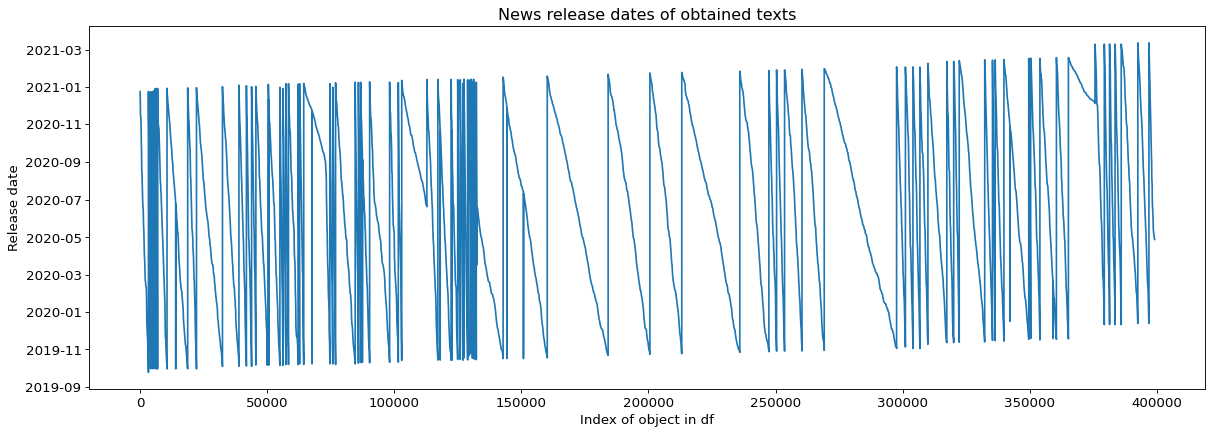

In [150]:
all_headlines_df['versionCreated'].plot(figsize=(18,6))
plt.xlabel('Index of object in df')
plt.ylabel('Release date')
plt.title('News release dates of obtained texts')
# plt.grid(True, axis='x')
plt.savefig(path_project_folder + 'exhibits_saved/'+ 'News release dates of obtained texts', bbox_inches = "tight")

In [163]:
quasi_logger2 = pd.read_csv('C:/DAN/t_systems/trade_project/logger/' + 'quasi_logger_2021-02-18_v1.csv', sep=';')

c:\python37\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0,7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [164]:
quasi_logger['date_time'][:338269] = quasi_logger2['date_time']

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [171]:
quasi_logger

,ric_i,ric_now,headlines_slice_i,headlines_number,up_to_date_ric,story_i,story_id_now,story_is_success,date_time,date_only,exec_seconds
0,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,0.0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,True,2020-12-24 03:51:31.939240,2020-12-24,NaN
1,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,1.0,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,True,2020-12-24 03:51:33.740708,2020-12-24,1.801468
2,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,2.0,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,True,2020-12-24 03:51:37.079818,2020-12-24,3.339110
3,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,3.0,urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,True,2020-12-24 03:51:37.803316,2020-12-24,0.723498
4,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,4.0,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,True,2020-12-24 03:51:38.957981,2020-12-24,1.154665
...,...,...,...,...,...,...,...,...,...,...,...
368537,39,ABBV.N,22.0,100.0,2020-04-27 17:03:55.441000+00:00,95.0,urn:newsml:reuters.com:20200423:nRSW6841Ka:1,False,2021-03-13 03:56:26.107769,2021-03-13,5.098304
368538,39,ABBV.N,22.0,100.0,2020-04-27 17:03:55.441000+00:00,96.0,urn:newsml:reuters.com:20200423:nBwbHxSr1a:1,False,2021-03-13 03:56:31.211766,2021-03-13,5.103997
368539,39,ABBV.N,22.0,100.0,2020-04-27 17:03:55.441000+00:00,97.0,urn:newsml:reuters.com:20200423:nBw24F12Wa:1,False,2021-03-13 03:56:36.310899,2021-03-13,5.099133
368540,39,ABBV.N,22.0,100.0,2020-04-27 17:03:55.441000+00:00,98.0,urn:newsml:newsroom:20200423:nRSW6746Ka:0,False,2021-03-13 03:56:41.415444,2021-03-13,5.104545


In [172]:
# Сохранить версию all_headlines_df вручную
save_file_as_new_file_without_replacing(
    path_project_folder=path_project_folder,
    folder_name_to_save=folder_name_headlines,
    file_to_save=all_headlines_df,
    file_short_name_add_to_path='all_headlines_df')

C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-03-13_v3.csv


In [173]:
# Сохранить версию логгера вручную
save_file_as_new_file_without_replacing(
    path_project_folder=path_project_folder,
    folder_name_to_save=folder_name_logger,
    file_to_save=quasi_logger,
    file_short_name_add_to_path='quasi_logger')

C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-03-13_v8.csv


In [166]:
print('df shape:', all_headlines_df.shape, ',  Num of rics:', all_headlines_df.groupby('ric')['ric'].nunique().sort_values(ascending=False).count())
print('StoryId duplicated:', all_headlines_df['storyId'].duplicated().sum())
print('Rows in df duplicated:', all_headlines_df.duplicated().sum())
print()
print('status error_when_trying_to_collect_story:', all_headlines_df[all_headlines_df['story'] == 'error_when_trying_to_collect_story']['story'].count())
print()
print('    Number of NA:')
print(len(all_headlines_df) - all_headlines_df.notna().sum())

df shape: (399141, 6) ,  Num of rics: 87
StoryId duplicated: 68132
Rows in df duplicated: 4343

status error_when_trying_to_collect_story: 1709

    Number of NA:
ric                 0
versionCreated      0
headline            0
storyId             0
sourceCode          0
story             153
dtype: int64


Median query time execution: 0.633312


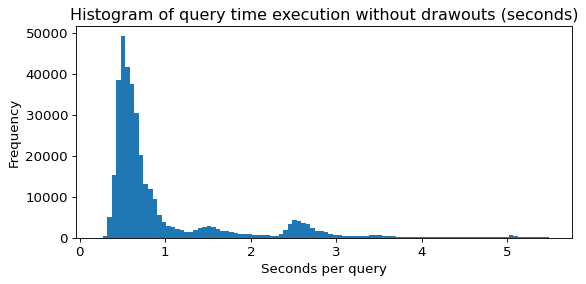

In [167]:
quasi_logger['date_time'] = pd.to_datetime(quasi_logger['date_time'])
quasi_logger['date_only'] = quasi_logger['date_time'].dt.date
quasi_logger['exec_seconds'] = quasi_logger['date_time'].diff() / np.timedelta64(1, 's')
exec_time_q99 = quasi_logger[
    (quasi_logger['exec_seconds'] < quasi_logger['exec_seconds'].quantile(0.99))
    & (quasi_logger['exec_seconds'] > 0)
]
exec_time_q99['exec_seconds'].plot(kind='hist', bins = 100)
plt.title('Histogram of query time execution without drawouts (seconds)')
plt.xlabel('Seconds per query')
plt.ylabel('Frequency')
# plt.grid(True, axis='x')
plt.savefig(path_project_folder + 'exhibits_saved/'+ 'Histogram of query time execution without drawouts (seconds)', bbox_inches = "tight")
print('Median query time execution:', quasi_logger['exec_seconds'].median())

<AxesSubplot:ylabel='ric_now'>

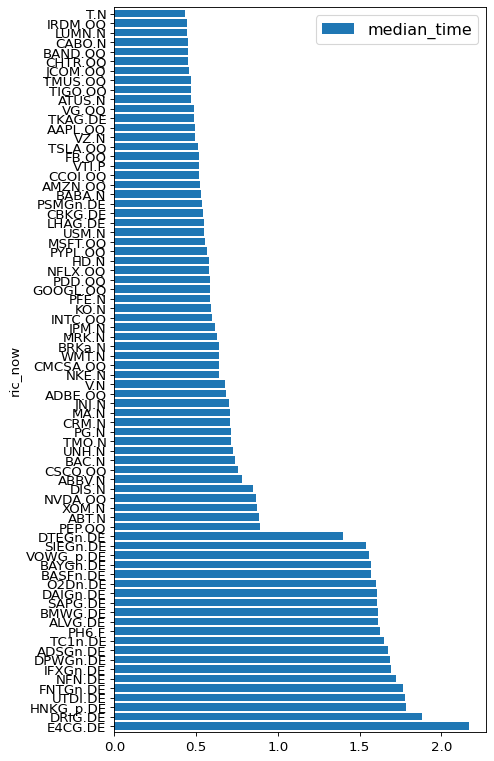

In [168]:
exec_time_q99.groupby(by='ric_now').agg(
    median_time=('exec_seconds', 'median')
).sort_values(by='median_time', ascending=False).plot(
    kind='barh', width=0.8, figsize=(6,12)
)

<AxesSubplot:ylabel='date_only'>

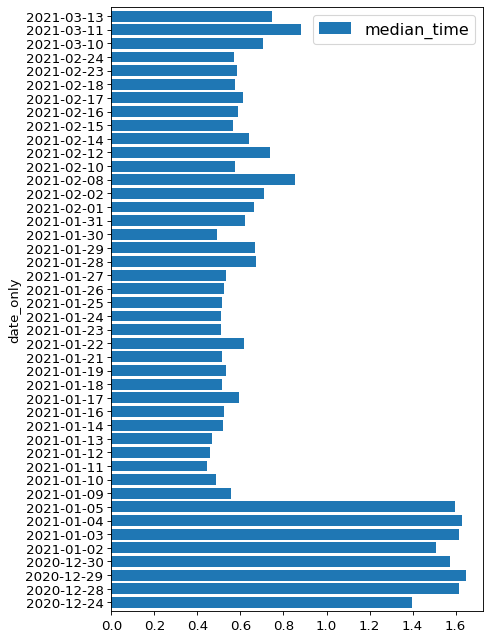

In [169]:
exec_time_q99.groupby(by='date_only').agg(
    median_time=('exec_seconds', 'median')
).plot(
    kind='barh', width=0.8, figsize=(6,10)
)

<AxesSubplot:ylabel='ric_now'>

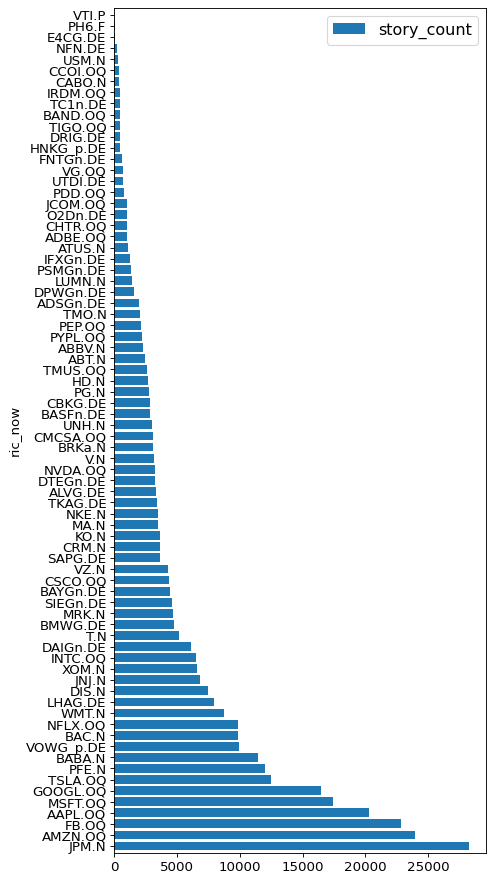

In [170]:
exec_time_q99.groupby(by='ric_now').agg(
    story_count=('story_id_now', 'count')
).sort_values(by='story_count', ascending=False).plot(
    kind='barh', width=0.8, figsize=(6,14)
)